In [1]:
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame,Series
import math
import time
import matplotlib.pylab as pltt
import scipy.sparse as sps

In [2]:
Re = 400
rho = 1
L = 1
V = 1
mu = rho*V*L/Re
w = 1

In [11]:
meshx = 4
deltax = L/meshx

meshy = meshx
deltay = L/meshy

mesht = 2 #para o primeiro tempo as velocidades e a pressão são zero
deltat = 1e50

In [12]:
P = np.zeros(((mesht,meshx,meshy)))
u = np.zeros(((mesht,meshx,meshy)))
v = np.zeros(((mesht,meshx,meshy)))

In [13]:
# Massa do Volume de Controle
Mp=rho*deltax*deltay*w
# Termos Difusivos
De_u=mu*deltay*w/deltax
De_v=mu*deltay*w/deltax
Dw_u=mu*deltay*w/deltax
Dw_v=mu*deltay*w/deltax
Dn_u=mu*deltax*w/deltay
Dn_v=mu*deltax*w/deltay
Ds_u=mu*deltax*w/deltay
Ds_v=mu*deltax*w/deltay

#a_p_o_u=(M_p/deltat)*ones(NTx,NTy)
#a_p_o_v=(M_p/deltat)*ones(NTx,NTy)



In [14]:
#posição em relação a manlha da pressão
x_plot = np.zeros(meshx)
y_plot = np.zeros(meshy)
t_plot = np.zeros(mesht)

x_plot = np.linspace(-deltax/2,L-deltax/2,meshx)
y_plot = np.linspace(-deltay/2,L-deltay/2,meshy)

In [54]:
#CDS
Me_u = np.zeros((meshx,meshy))
Mw_u = np.zeros((meshx,meshy))
Mn_u = np.zeros((meshx,meshy))
Ms_u = np.zeros((meshx,meshy))

Me_v = np.zeros((meshx,meshy))
Mw_v = np.zeros((meshx,meshy))
Mn_v = np.zeros((meshx,meshy))
Ms_v = np.zeros((meshx,meshy))

ae_u = np.zeros((meshx,meshy))
aw_u = np.zeros((meshx,meshy))
an_u = np.zeros((meshx,meshy))
as_u = np.zeros((meshx,meshy))
ap0_u = np.zeros((meshx,meshy))
b_u = np.zeros((meshx,meshy))
ap_u = np.zeros((meshx,meshy))
ae_v = np.zeros((meshx,meshy))
aw_v = np.zeros((meshx,meshy))
an_v = np.zeros((meshx,meshy))
as_v = np.zeros((meshx,meshy))
ap0_v = np.zeros((meshx,meshy))
b_v = np.zeros((meshx,meshy))
ap_v = np.zeros((meshx,meshy))

u_antigo = np.zeros((meshx,meshy))
v_antigo = np.zeros((meshx,meshy))
P_antigo = np.zeros((meshx,meshy))

eps = 1e-8
erro = 1
for t in range(1,mesht):
    iteracoes = 0
    while (erro > eps): #arrumar dps
        u_antigo[:,:] = u[t,:,:]
        v_antigo[:,:] = v[t,:,:]
        P_antigo[:,:] = P[t,:,:]
        
        for y in range(1,meshy-1):
            for x in range(1,meshx-1):            
                Me_u[x,y] = rho*(u[t,x,y]+u[t,x+1,y])/2*deltay*w
                Mw_u[x,y] = rho*(u[t,x,y]+u[t,x-1,y])/2*deltay*w
                Mn_u[x,y] = rho*(v[t,x,y]+v[t,x+1,y])/2*deltax*w
                Ms_u[x,y] = rho*(v[t,x,y-1]+v[t,x+1,y-1])/2*deltax*w
                
                Me_v[x,y] = rho*(u[t,x,y]+u[t,x,y+1])/2*deltay*w
                Mw_v[x,y] = rho*(u[t,x-1,y+1]+u[t,x-1,y])/2*deltay*w
                Mn_v[x,y] = rho*(v[t,x,y]+v[t,x,y+1])/2*deltax*w
                Ms_v[x,y] = rho*(v[t,x,y]+v[t,x,y-1])/2*deltax*w

                ae_u[x,y] = De_u - Me_u[x,y]/2
                aw_u[x,y] = Dw_u + Mw_u[x,y]/2
                an_u[x,y] = Dn_u - Mn_u[x,y]/2
                as_u[x,y] = Ds_u + Ms_u[x,y]/2
                ap0_u[x,y] = Mp/deltat
                b_u[x,y] =ap0_u[x,y]*u[t-1,x,y]
                ap_u[x,y] = ae_u[x,y] + aw_u[x,y] + an_u[x,y] + as_u[x,y] + ap0_u[x,y]
                
                ae_v[x,y] = De_v - Me_v[x,y]/2
                aw_v[x,y] = Dw_v + Mw_v[x,y]/2
                an_v[x,y] = Dn_v - Mn_v[x,y]/2
                as_v[x,y] = Ds_v + Ms_v[x,y]/2
                ap0_v[x,y] = Mp/deltat
                b_v[x,y] =ap0_v[x,y]*v[t-1,x,y]
                ap_v[x,y] = ae_v[x,y] + aw_v[x,y] + an_v[x,y] + as_v[x,y] + ap0_v[x,y]
        ##Condições de contorno para C.Q.M em x:
        #face esquerda        
        for y in range(meshy):
            ap_u[0,y] = 1
            b_u[0,y] = 0
            
        #face direita
        for y in range(meshy):
            ap_u[meshx-1,y] = 1
            b_u[meshx-1,y] = 0
            
        #face norte
        for x in range(1,meshx-1):
            ae_u[x,meshy-1] = De_u - Me_u[x,meshy-1]/2
            aw_u[x,meshy-1] = Dw_u + Mw_u[x,meshy-1]/2
            an_u[x,meshy-1] = 0
            as_u[x,meshy-1] = Ds_u +Ms_u[x,meshy-1]/2
            ap0_u[x,meshy-1] = Mp/deltat
            b_u[x,meshy-1] = ap0_u[x,meshy-1]*u[t-1,x,meshy-1] + 2*Dn_u*V
            ap_u[x,meshy-1] = ae_u[x,meshy-1] + aw_u[x,meshy-1] + an_u[x,meshy-1] + as_u[x,meshy-1] + ap0_u[x,meshy-1] +2*Ds_u
            
        #face sul ficticia -> não importa os valores de u
        for x in range(meshx):
            ap_u[x,0] = 1
            b_u[x,0] = 0
            
        #face sul real
        for x in range(1,meshx-1):
            ae_u[x,1] = De_u - Me_u[x,1]/2
            aw_u[x,1] = Dw_u + Mw_u[x,1]/2
            an_u[x,1] = Dn_u - Mn_u[x,1]/2
            as_u[x,1] = 0
            ap0_u[x,1] = Mp/deltat
            b_u[x,1] = ap0_u[x,1]*u[t-1,x,1]
            ap_u[x,1] = ae_u[x,1] + aw_u[x,1] + an_u[x,1] + as_u[x,1] + ap0_u[x,1] +2*Ds_u
        ##Fim CC para C.Q.M. em x
        
        ##Condições de contorno para C.Q.M em y:
        #face norte
        for x in range(meshx):
            ap_v[x,meshy-1] = 1
            b_v[x,meshy-1] = 0
           
        #face sul
        for x in range(meshx):
            ap_v[x,0] = 1
            b_v[x,0] = 0
            
        #face esquerda ficticia -> não importa valores de v nesses pontos
        for y in range(meshy):
            ap_v[0,y] = 1
            b_v[0,y] = 0
            
        #face esquerda real
        for y in range(1,meshy-1):
            ae_v[1,y] = De_v - Me_v[1,y]/2 
            aw_v[1,y] = 0
            an_v[1,y] = Dn_v - Mn_v[1,y]/2
            as_v[1,y] = Ds_v + Ms_v[1,y]/2
            ap0_v[1,y] = Mp/deltat
            b_v[1,y] = ap0_v[1,y]*v[t-1,1,y]
            ap_v[1,y] = ae_v[1,y] + aw_v[1,y] + an_v[1,y] + as_v[1,y] + ap0_v[1,y] + 2*Dw_v
            
        #face direita
        for y in range(1,meshy-1):
            ae_v[meshx-1,y] = 0
            aw_v[meshx-1,y] = Dw_v + Mw_v[meshx-1,y]/2
            an_v[meshx-1,y] = Dn_v - Mn_v[meshx-1,y]/2
            as_v[meshx-1,y] = Ds_v + Ms_v[meshx-1,y]/2
            ap0_v[meshx-1,y] = Mp/deltat
            b_v[meshx-1,y] = ap0_v[1,y]*v[t-1,meshx-1,y]
            ap_v[meshx-1,y] = ae_v[meshx-1,y] + aw_v[meshx-1,y] + an_v[meshx-1,y] + as_v[meshx-1,y] + ap0_v[meshx-1,y] + 2*De_v
        ##Fim CC para C.Q.M. em y
        
        #Montando a matriz de coef
        Matrix_coef_A = np.zeros((3*meshx*meshy,3*meshx*meshy))
        Matrix_coef_B = np.zeros((3*meshx*meshy,1))
        cont = 0
        
        #1º quadrante
        for y in range(meshy):
            for x in range(meshx):
                Matrix_coef_A[cont,cont] = ap_u[x,y]
                if (cont < meshx*meshy-1):
                    Matrix_coef_A[cont,cont+1] = -ae_u[x,y]
                if (cont > 0):
                    Matrix_coef_A[cont,cont-1] = -aw_u[x,y]
                if (cont < meshx*meshy - meshx):
                    Matrix_coef_A[cont,cont+meshx] = -an_u[x,y]
                if (cont > meshx-1):
                    Matrix_coef_A[cont,cont-meshx] = -as_u[x,y]
                Matrix_coef_B[cont,0] = b_u[x,y]
                #3º quadrante
                if (x != 0) and (y != 0) and (x != meshx-1):
                    Matrix_coef_A[cont, cont + 2*meshx*meshy] = -w*deltay
                    if (cont < meshx*meshy-1):
                        Matrix_coef_A[cont, cont + 2*meshx*meshy+1] = w*deltay
                cont += 1
                
        #5º quadrante
        cont = meshx*meshy
        for y in range(meshy):
            for x in range(meshx):
                Matrix_coef_A[cont,cont] = ap_v[x,y]
                if (cont < 2*meshx*meshy-1):
                    Matrix_coef_A[cont,cont+1] = -ae_v[x,y]
                if (cont >meshx*meshy):
                    Matrix_coef_A[cont,cont-1] = -aw_v[x,y]
                if (cont < 2*meshx*meshy - meshx):
                    Matrix_coef_A[cont,cont+meshx] = -an_v[x,y]
                if (cont > meshx*meshy + meshx-1):
                    Matrix_coef_A[cont,cont-meshx] = as_v[x,y]
                Matrix_coef_B[cont,0] = b_v[x,y]
                #6º quadrante
                if (x != 0) and (y != 0) and (y != meshy-1):
                    Matrix_coef_A[cont, cont + meshx*meshy] = w*deltax
                    if (cont < 2*meshx*meshy-meshx):
                        Matrix_coef_A[cont, cont + meshx*meshy+meshx] = -w*deltax
                cont += 1
                
        #7º quadrante
        cont = 2*meshx*meshy
        i = 0
        for y in range(meshy):
            for x in range(meshx):
                if (x != 0) and (y != 0):
                    Matrix_coef_A[cont,i] = deltay*w
                    Matrix_coef_A[cont,i-1] = -deltax*w

                    #8º quadrante
                    Matrix_coef_A[cont,i+meshx*meshy] = deltax*w
                    Matrix_coef_A[cont,i+meshx*meshy-meshx] = -deltax*w
                cont += 1
                i += 1
            
        cont = 2*meshx*meshy
        #9º quadrante
        for y in range(meshy):
            for x in range(meshx):
                #para os volumes ficticios, pressão = 0
                if (x==0) or (y == 0):
                    Matrix_coef_A[cont,cont] = 1
                cont += 1
        #determinando pressão de referência = 0 no último volume
        Matrix_coef_A[meshx*meshy*3-1,meshx*meshy*3-1] = 1
        
        Resultado = solve(Matrix_coef_A,Matrix_coef_B)
        cont = 0
        for y in range(meshy):
            for x in range(meshx):
                u[t,x,y] = Resultado[cont,0]
        cont = meshx*meshy
        for y in range(meshy):
            for x in range(meshx):
                v[t,x,y] = Resultado[cont,0]
        cont = meshx*meshy*2
        for y in range(meshy):
            for x in range(meshx):
                P[t,x,y] = Resultado[cont,0]
                
        erro_u = (u[t,:,:] - u_antigo[:,:])
        erro_v = (v[t,:,:] - v_antigo[:,:])
        erro_P = (P[t,:,:] - v_antigo[:,:])
        erro = max(abs(erro_u.max()),abs(erro_v.max()),abs(erro_P.max()))
        iteracoes += 1
        print(iteracoes)
        #erro = 0 #mudar dps
                

1


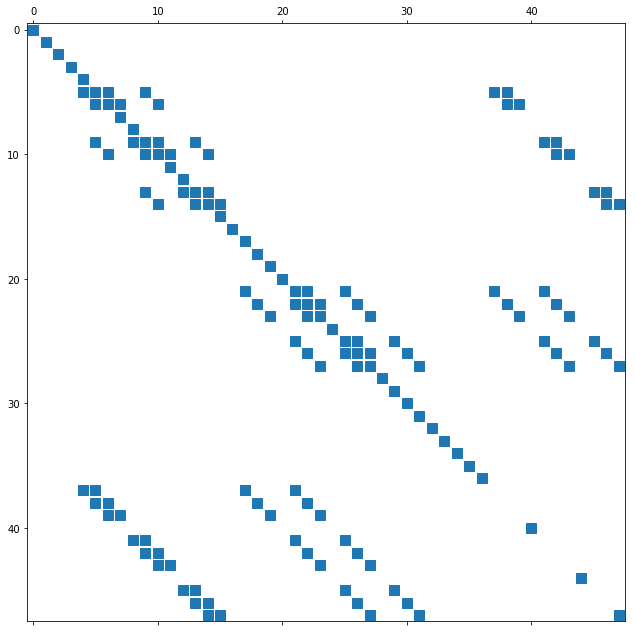

In [55]:
%matplotlib inline
M = sps.csr_matrix(Matrix_coef_A)
fig, ax = pltt.subplots(figsize=(11,11))
ax.spy(M)


C:\Users\Gusttav\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


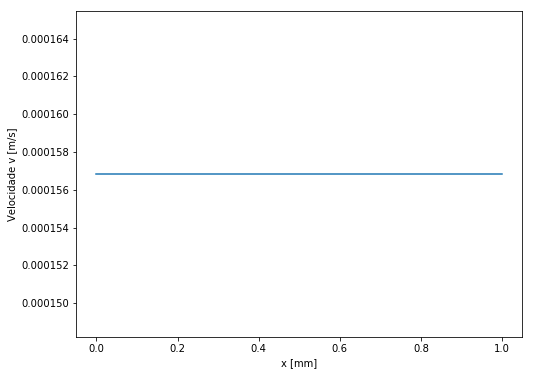

In [44]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
axis = fig.add_subplot(111)   

axis.plot(x_plot+deltax/2,v[1,:,(meshx-1)/2])

axis.set_ylabel('Velocidade v [m/s]')
axis.set_xlabel('x [mm]')
axis.set_title('')
axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axis.set_ylim(30,100)
#axis.set_xlim(-0.05,0.45)
